In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# TODO: add files from which we import functions
from scripts import (
    load_joined_data,
    split_data,
    cap_outliers,
    remove_seasonality_ia,
    restore_seasonality_ia,
    add_lags,
    evaluate_feature_importance,
    dnn,
    mean_absolute_percentage_error,
)

from catboost import CatBoostRegressor
from deepforest import CascadeForestRegressor
from xgboost import XGBRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit

START = datetime(2021, 4, 1, 9, 30)
END = datetime(2022, 4, 1, 16, 0)
BUCKET = 600  # seconds

COLUMNS = ["VOLUME_fut", "VOLUME_etf", "VOLUME_opt"]
TARGET = "VOLUME_fut_target"

if not ("REMOVE_SEASONALITY" in locals() or "REMOVE_SEASONALITY" in globals()):
    REMOVE_SEASONALITY = True
if not ("PLOT_CHARTS" in locals() or "PLOT_CHARTS" in globals()):
    PLOT_CHARTS = True
FOLDS_NUM = 10

/home/otestov/code/ml/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-08 21:41:06.026611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-08 21:41:06.026634: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ts = load_joined_data(common_kwargs=dict(start=START, end=END, bucket=BUCKET))

In [3]:
# load cached data
ts = load_joined_data(
    pd.read_csv('./data/etf_nq.csv', index_col='Time'),
    pd.read_csv('./data/fut_nq.csv', index_col='Time'),
    pd.read_csv('./data/opt_nq.csv', index_col='Time'),
)
ts

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,31967,5787283,20914,940,31967
1,2021-04-01 09:50:00,13194,3001767,14998,950,13194
2,2021-04-01 10:00:00,9774,1523707,9644,1000,9774
3,2021-04-01 10:10:00,26026,3199697,17938,1010,26026
4,2021-04-01 10:20:00,10889,2662730,12092,1020,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,8872,1283681,18724,1520,8872
9847,2022-03-31 15:30:00,12924,1501646,12523,1530,12924
9848,2022-03-31 15:40:00,16582,1970892,18835,1540,16582
9849,2022-03-31 15:50:00,13761,2629317,15626,1550,13761


# Preparing Data

In [4]:
# TODO: we do not need validation set for now
# split data into training, validation, and test sets (15% each for val and test)
train_indexes, val_indexes, test_indexes = split_data(ts, val_size = 0.15, test_size = 0.15)

# cap outliers to within 4 standard deviations from the mean
ts = cap_outliers(ts, train_indexes, COLUMNS, std_num=4)

# remove seasonality by normalizing based on the intraday average
if REMOVE_SEASONALITY:
    ts = remove_seasonality_ia(ts, COLUMNS, bins=39, window_days=20)

# TODO: remove a line below but apply scaler inverse transform for baseline
df_prep = ts.copy()

# scale data to the range [0, 1]
scaler = MinMaxScaler()

train = df_prep.loc[train_indexes, COLUMNS+["hhmm"]]
val = df_prep.loc[val_indexes, COLUMNS+["hhmm"]]
test = df_prep.loc[test_indexes, COLUMNS+["hhmm"]]

df_prep.loc[train_indexes, COLUMNS+["hhmm"]] = scaler.fit_transform(train)
df_prep.loc[val_indexes, COLUMNS+["hhmm"]] = scaler.transform(val)
df_prep.loc[test_indexes, COLUMNS+["hhmm"]] = scaler.transform(test)

df_prep

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target,VOLUME_fut_agg
0,2021-04-01 09:40:00,NaN,NaN,NaN,0.000000,NaN,NaN
1,2021-04-01 09:50:00,NaN,NaN,NaN,0.015152,NaN,NaN
2,2021-04-01 10:00:00,NaN,NaN,NaN,0.090909,NaN,NaN
3,2021-04-01 10:10:00,NaN,NaN,NaN,0.106061,NaN,NaN
4,2021-04-01 10:20:00,NaN,NaN,NaN,0.121212,NaN,NaN
...,...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,0.245461,0.331551,0.356828,0.878788,-1088.95,9960.95
9847,2022-03-31 15:30:00,0.338251,0.330619,0.241341,0.893939,3112.50,9811.50
9848,2022-03-31 15:40:00,0.398719,0.389454,0.336081,0.909091,5850.40,10731.60
9849,2022-03-31 15:50:00,0.324041,0.440422,0.280734,0.924242,2469.05,11291.95


# Add Lags As Features

In [5]:
df = df_prep[COLUMNS + [TARGET, "hhmm"]].copy()
df, lags_columns = add_lags(
    df, COLUMNS, periods=[1, 2, 3, 4, 38, 39, 78, 195]
)
df = df.dropna()
train_indexes = df.index.intersection(train_indexes)
df[lags_columns]

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_38,VOLUME_fut_lag_39,VOLUME_fut_lag_78,VOLUME_fut_lag_195,VOLUME_etf_lag_1,VOLUME_etf_lag_2,VOLUME_etf_lag_3,VOLUME_etf_lag_4,VOLUME_etf_lag_38,VOLUME_etf_lag_39,VOLUME_etf_lag_78,VOLUME_etf_lag_195,VOLUME_opt_lag_1,VOLUME_opt_lag_2,VOLUME_opt_lag_3,VOLUME_opt_lag_4,VOLUME_opt_lag_38,VOLUME_opt_lag_39,VOLUME_opt_lag_78,VOLUME_opt_lag_195
975,0.376834,0.298806,0.238562,0.271005,0.273178,0.346505,0.286090,0.210066,0.605009,0.418848,0.331005,0.344279,0.442242,0.590585,0.534640,0.403410,0.266502,0.345533,0.242103,0.464259,0.223263,0.408818,0.452837,0.633626
976,0.452274,0.376834,0.298806,0.238562,0.334954,0.273178,0.266559,0.229964,0.701490,0.605009,0.418848,0.331005,0.441935,0.442242,0.521533,0.315396,0.570990,0.266502,0.345533,0.242103,0.187002,0.223263,0.300635,0.360554
977,0.483536,0.452274,0.376834,0.298806,0.273664,0.334954,0.247986,0.270074,0.683503,0.701490,0.605009,0.418848,0.421329,0.441935,0.428100,0.362009,0.591301,0.570990,0.266502,0.345533,0.222492,0.187002,0.271625,0.315773
978,0.236553,0.483536,0.452274,0.376834,0.369192,0.273664,0.439917,0.236121,0.419994,0.683503,0.701490,0.605009,0.435440,0.421329,0.586407,0.326581,0.351590,0.591301,0.570990,0.266502,0.213914,0.222492,0.395793,0.335621
979,0.286146,0.236553,0.483536,0.452274,0.287599,0.369192,0.312709,0.257731,0.490809,0.419994,0.683503,0.701490,0.422535,0.435440,0.428752,0.291200,0.416941,0.351590,0.591301,0.570990,0.252861,0.213914,0.410032,0.222415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9846,0.299900,0.210771,0.221519,0.240745,0.387180,0.321667,0.219864,0.187098,0.444506,0.286161,0.310881,0.331240,0.526490,0.478479,0.367247,0.284853,0.392888,0.271970,0.204026,0.211988,0.261588,0.394660,0.254279,0.246151
9847,0.245461,0.299900,0.210771,0.221519,0.326238,0.387180,0.232577,0.252732,0.331551,0.444506,0.286161,0.310881,0.352252,0.526490,0.509997,0.289730,0.356828,0.392888,0.271970,0.204026,0.211539,0.261588,0.206858,0.338705
9848,0.338251,0.245461,0.299900,0.210771,0.294482,0.326238,0.236148,0.199913,0.330619,0.331551,0.444506,0.286161,0.342792,0.352252,0.356550,0.252679,0.241341,0.356828,0.392888,0.271970,0.277489,0.211539,0.181920,0.189213
9849,0.398719,0.338251,0.245461,0.299900,0.212750,0.294482,0.249524,0.168574,0.389454,0.330619,0.331551,0.444506,0.359388,0.342792,0.387799,0.203799,0.336081,0.241341,0.356828,0.392888,0.116164,0.277489,0.203963,0.155145


## Features Importance

Feature Importance: model is not specified, using CatBoostRegressor


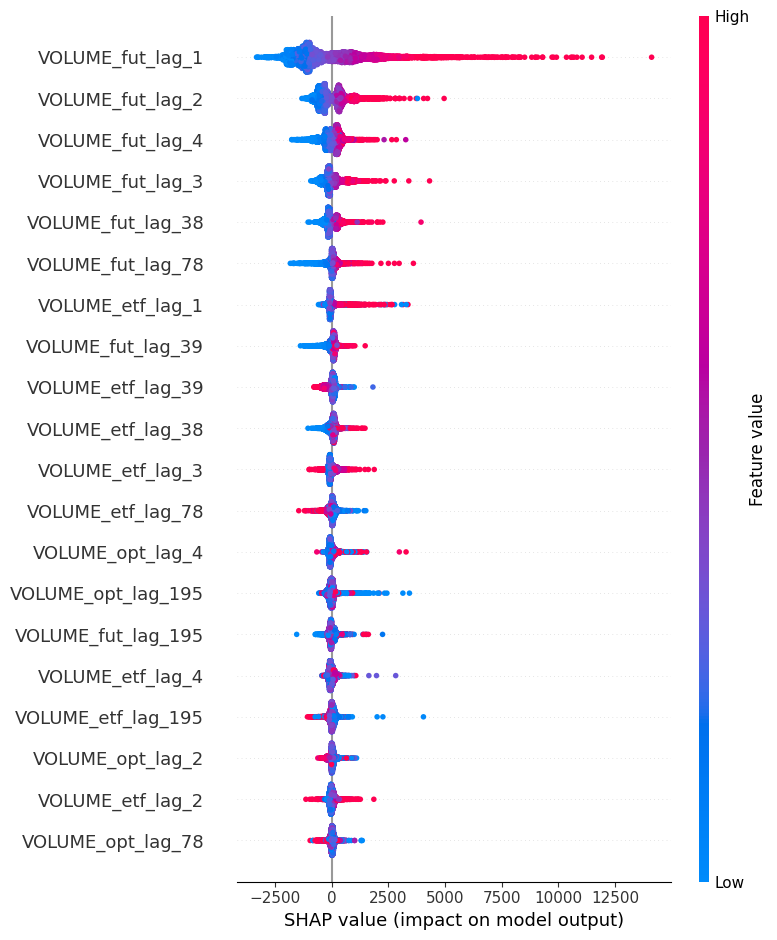

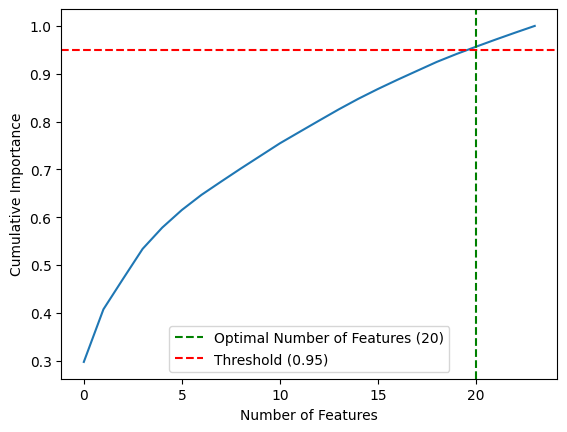

In [6]:
top_features = evaluate_feature_importance(
    df, train_indexes, lags_columns, TARGET, threshold=0.95, plot=PLOT_CHARTS
)

# Training

In [7]:
if not REMOVE_SEASONALITY:
    top_features = list(top_features) + ["hhmm"]
x_train, x_val, x_test = df.loc[train_indexes, top_features], df.loc[val_indexes, top_features], df.loc[test_indexes, top_features]
y_train, y_val, y_test = df.loc[train_indexes, TARGET], df.loc[val_indexes, TARGET], df.loc[test_indexes, TARGET]
metrics = {}

## Baseline Model

In [8]:
df = ts.copy()
df['VOLUME_fut_pred'] = df[TARGET].shift(1)

if REMOVE_SEASONALITY:
    df = restore_seasonality_ia(df)
else:
    df.loc[df['hhmm']==940, 'VOLUME_fut_pred'] = df.loc[df['hhmm']==940, TARGET].shift(1)
    df.loc[df['hhmm']==1600, 'VOLUME_fut_pred'] = df.loc[df['hhmm']==1600, TARGET].shift(1)

df_test = df.loc[test_indexes]

metrics_baseline = {"baseline": {
    'R2': r2_score(df_test[TARGET], df_test['VOLUME_fut_pred']),
    'MAE': mean_absolute_error(df_test[TARGET], df_test['VOLUME_fut_pred']),
    'MAPE': mean_absolute_percentage_error(df_test[TARGET], df_test['VOLUME_fut_pred'])
    }
}
metrics_baseline

{'baseline': {'R2': 0.6902063654384585,
  'MAE': 2619.460641838839,
  'MAPE': 0.21368642437336993}}

## Simple Models

### Determine Models

In [9]:
xgb = XGBRegressor()
cat = CatBoostRegressor()
cfr = CascadeForestRegressor()
dnn = KerasRegressor(
    model=dnn,
    loss='mean_squared_error',
    optimizer='adam',
    # TODO: remove parameters below from here
    hid_layers_num=2,
    neurons_num_layer1=4,
    activation_layer1='relu',
    dropout_layer1=0,
    neurons_num_layer2=4,
    activation_layer2='relu',
    dropout_layer2=0,
    batch_size=32,
    epochs=3,
    verbose=0,
    random_seed=42,
)

### Models Parameters

In [10]:
models = {
    'xgboost': {
        'class': xgb, 
        'init_params': {
            'n_estimators': [100], 
            'max_depth': [3, 4], 
            'learning_rate': [0.1], 
            'verbosity': [0],
            'n_jobs': [4],
            'random_state': [42]
            },
        'fit_params': {'verbose': False}
        },
    'catboost': {
        'class': cat, 
        'init_params': {
            'n_estimators': [100],
            'max_depth': [3, 4],
            'learning_rate': [0.1],
            'verbose': [0],
            'thread_count': [4],
            'random_seed': [42]
            },
        'fit_params': {'verbose': False}
        },
    'cascadeforest': {
        'class': cfr,
        'init_params': {
            'n_estimators': [1, 2, 3],
            'n_trees': [100],
            'max_depth': [3, 4],
            'max_layers': [5, 10],
            'use_predictor': [False, True],
            'predictor': ["lightgbm"],
            'verbose': [0],
            'n_jobs': [4],
            'random_state': [42]
            },
        'fit_params': {}
    },
    'dnn': {
        'class': dnn,
        'init_params': {
            'hid_layers_num': [2],
            'neurons_num_layer1': [45],
            'activation_layer1': ['tanh'],
            'dropout_layer1': [0],
            'neurons_num_layer2': [45],
            'activation_layer2': ['relu'],
            'dropout_layer2': [0],
            'batch_size': [16],
            'epochs': [100],
            'verbose': [0],
            'random_seed': [42]
            },
        'fit_params': {'verbose': False}
    }
}

### Determine Metrics + Include Inverse Transform

In [11]:
def prepare_data_to_evaluate(estimator, X):
    y_pred = pd.DataFrame(estimator.predict(X), index=X.index, columns=['VOLUME_fut_pred'])
    tdf_test = y_pred.join(ts)
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(tdf_test)
    return tdf_test

def custom_r2_metric(estimator, X, y_true):
    tdf_test = prepare_data_to_evaluate(estimator, X)
    r2 = r2_score(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    return r2

def custom_mape_metric(estimator, X, y_true):
    tdf_test = prepare_data_to_evaluate(estimator, X)
    mape = mean_absolute_percentage_error(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    return mape

# will use MAE as scorer (other metrics only for information)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

### GSCV

In [12]:
cv_metrics = pd.DataFrame()
sklearn_params = dict(
                scoring={
                    'MAE': mae_scorer, 
                    'R2': custom_r2_metric, 
                    'MAPE': custom_mape_metric
                },
                cv=TimeSeriesSplit(n_splits=FOLDS_NUM),
                refit='MAE',
                verbose=False,
                n_jobs=4,
            )
best_estimators = {}
for model_name, model_params in models.items():
    print(f"Training {model_name}...")
    gscv = GridSearchCV(
        model_params['class'],
        model_params['init_params'],
        **sklearn_params
    )
    gscv.fit(
        pd.concat([x_train, x_val]),
        np.ravel(pd.concat([y_train, y_val])),
        **model_params['fit_params']
    )
    
    cv_df = pd.DataFrame(gscv.cv_results_)[['params', 
                                            'mean_test_MAE', 'std_test_MAE', 
                                            'mean_test_MAPE', 'std_test_MAPE',
                                            'mean_test_R2', 'std_test_R2']]
    cv_df['mean_test_MAE'] = cv_df['mean_test_MAE'].abs()
    cv_df['model'] = model_name
    cv_metrics = pd.concat([cv_metrics, cv_df], ignore_index=True)
    print("Best mean test score:", gscv.best_score_)
    best_estimators[model_name] = gscv.best_estimator_
cv_metrics.sort_values(["mean_test_MAE"])

Training xgboost...


2024-01-08 21:41:12.835067: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-08 21:41:12.835067: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-08 21:41:12.835092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-08 21:41:12.835093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-08 21:41:12.880364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Best mean test score: -2126.228943039486
Training catboost...
Best mean test score: -2122.3004429195726
Training cascadeforest...
Best mean test score: -2184.707096938931
Training dnn...


2024-01-08 21:46:10.197435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-08 21:46:10.197464: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-08 21:46:10.197484: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dev-host-1.eng.sol.onetick.com): /proc/driver/nvidia/version does not exist
2024-01-08 21:46:10.197673: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 21:46:10.204559: W tensorflow/stream_executor/platform/default/dso_loader

Best mean test score: -2238.8273807210176


,params,mean_test_MAE,std_test_MAE,mean_test_MAPE,std_test_MAPE,mean_test_R2,std_test_R2,model
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_seed': 42, 'thread_count': 4, 'verbose': 0}",2122.300443,320.547668,0.203411,0.028995,0.807317,0.044960,catboost
2,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_seed': 42, 'thread_count': 4, 'verbose': 0}",2125.392551,328.914677,0.204138,0.029340,0.807717,0.045725,catboost
0,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 4, 'random_state': 42, 'verbosity': 0}",2126.228943,316.663287,0.204616,0.026783,0.805216,0.040929,xgboost
1,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'n_jobs': 4, 'random_state': 42, 'verbosity': 0}",2159.955167,326.178951,0.207441,0.027737,0.800453,0.038883,xgboost
26,"{'max_depth': 4, 'max_layers': 10, 'n_estimators': 3, 'n_jobs': 4, 'n_trees': 100, 'predictor': 'lightgbm', 'random_state': 42, 'use_predictor': False, 'verbose': 0}",2184.707097,377.760402,0.211471,0.042192,0.797886,0.049827,cascadeforest
20,"{'max_depth': 4, 'max_layers': 5, 'n_estimators': 3, 'n_jobs': 4, 'n_trees': 100, 'predictor': 'lightgbm', 'random_state': 42, 'use_predictor': False, 'verbose': 0}",2186.889558,380.197555,0.211765,0.042671,0.797648,0.049787,cascadeforest
9,"{'max_depth': 3, 'max_layers': 5, 'n_estimators': 3, 'n_jobs': 4, 'n_trees': 100, 'predictor': 'lightgbm', 'random_state': 42, 'use_predictor': True, 'verbose': 0}",2197.434100,320.013978,0.212445,0.028424,0.796903,0.041389,cascadeforest
7,"{'max_depth': 3, 'max_layers': 5, 'n_estimators': 2, 'n_jobs': 4, 'n_trees': 100, 'predictor': 'lightgbm', 'random_state': 42, 'use_predictor': True, 'verbose': 0}",2202.252745,320.704803,0.213445,0.029033,0.796631,0.040974,cascadeforest
17,"{'max_depth': 4, 'max_layers': 5, 'n_estimators': 1, 'n_jobs': 4, 'n_trees': 100, 'predictor': 'lightgbm', 'random_state': 42, 'use_predictor': True, 'verbose': 0}",2203.916991,322.638090,0.212367,0.027409,0.797205,0.039460,cascadeforest
13,"{'max_depth': 3, 'max_layers': 10, 'n_estimators': 2, 'n_jobs': 4, 'n_trees': 100, 'predictor': 'lightgbm', 'random_state': 42, 'use_predictor': True, 'verbose': 0}",2205.444525,322.266835,0.213464,0.028780,0.796495,0.042183,cascadeforest


### Evaluation On The Test Set

In [13]:
metrics = {}
for model_name, estimator in best_estimators.items():
    y_pred = pd.DataFrame(estimator.predict(x_test), index=x_test.index, columns=['VOLUME_fut_pred'])
    tdf_test = y_pred.join(ts)
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(tdf_test)
    
    tdf_test.dropna(inplace=True)
    r2 = r2_score(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    mae = mean_absolute_error(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    mape = mean_absolute_percentage_error(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    
    metrics[model_name] = {
        'R2': r2,
        'MAE': mae,
        'MAPE': mape
    }
metrics_baseline, metrics

({'baseline': {'R2': 0.6902063654384585,
   'MAE': 2619.460641838839,
   'MAPE': 0.21368642437336993}},
 {'xgboost': {'R2': 0.7559628556651067,
   'MAE': 2284.2200561669324,
   'MAPE': 0.1942446642625584},
  'catboost': {'R2': 0.754837352365998,
   'MAE': 2297.0357660848376,
   'MAPE': 0.19365957252992838},
  'cascadeforest': {'R2': 0.753332508779933,
   'MAE': 2275.1247070101203,
   'MAPE': 0.1890195097662987},
  'dnn': {'R2': 0.757121198516554,
   'MAE': 2297.334898388562,
   'MAPE': 0.19591710985740135}})

### Ensemble Evaluation On The Test Set

In [14]:
y_pred = np.mean(
    [estimator.predict(x_test).flatten() for estimator in best_estimators.values()],
    axis=0,
)
y_pred = pd.DataFrame(y_pred, index=x_test.index, columns=["VOLUME_fut_pred"])
tdf_test = y_pred.join(ts)
if REMOVE_SEASONALITY:
    tdf_test = restore_seasonality_ia(tdf_test)

tdf_test.dropna(inplace=True)
r2 = r2_score(tdf_test[TARGET], tdf_test["VOLUME_fut_pred"])
mae = mean_absolute_error(tdf_test[TARGET], tdf_test["VOLUME_fut_pred"])
mape = mean_absolute_percentage_error(tdf_test[TARGET], tdf_test["VOLUME_fut_pred"])

metrics_ensemble = {"ensemble": {"R2": r2, "MAE": mae, "MAPE": mape}}
metrics_baseline, metrics, metrics_ensemble

({'baseline': {'R2': 0.6902063654384585,
   'MAE': 2619.460641838839,
   'MAPE': 0.21368642437336993}},
 {'xgboost': {'R2': 0.7559628556651067,
   'MAE': 2284.2200561669324,
   'MAPE': 0.1942446642625584},
  'catboost': {'R2': 0.754837352365998,
   'MAE': 2297.0357660848376,
   'MAPE': 0.19365957252992838},
  'cascadeforest': {'R2': 0.753332508779933,
   'MAE': 2275.1247070101203,
   'MAPE': 0.1890195097662987},
  'dnn': {'R2': 0.757121198516554,
   'MAE': 2297.334898388562,
   'MAPE': 0.19591710985740135}},
 {'ensemble': {'R2': 0.7590760765384623,
   'MAE': 2268.190029240627,
   'MAPE': 0.1914763582554568}})

<AxesSubplot:>

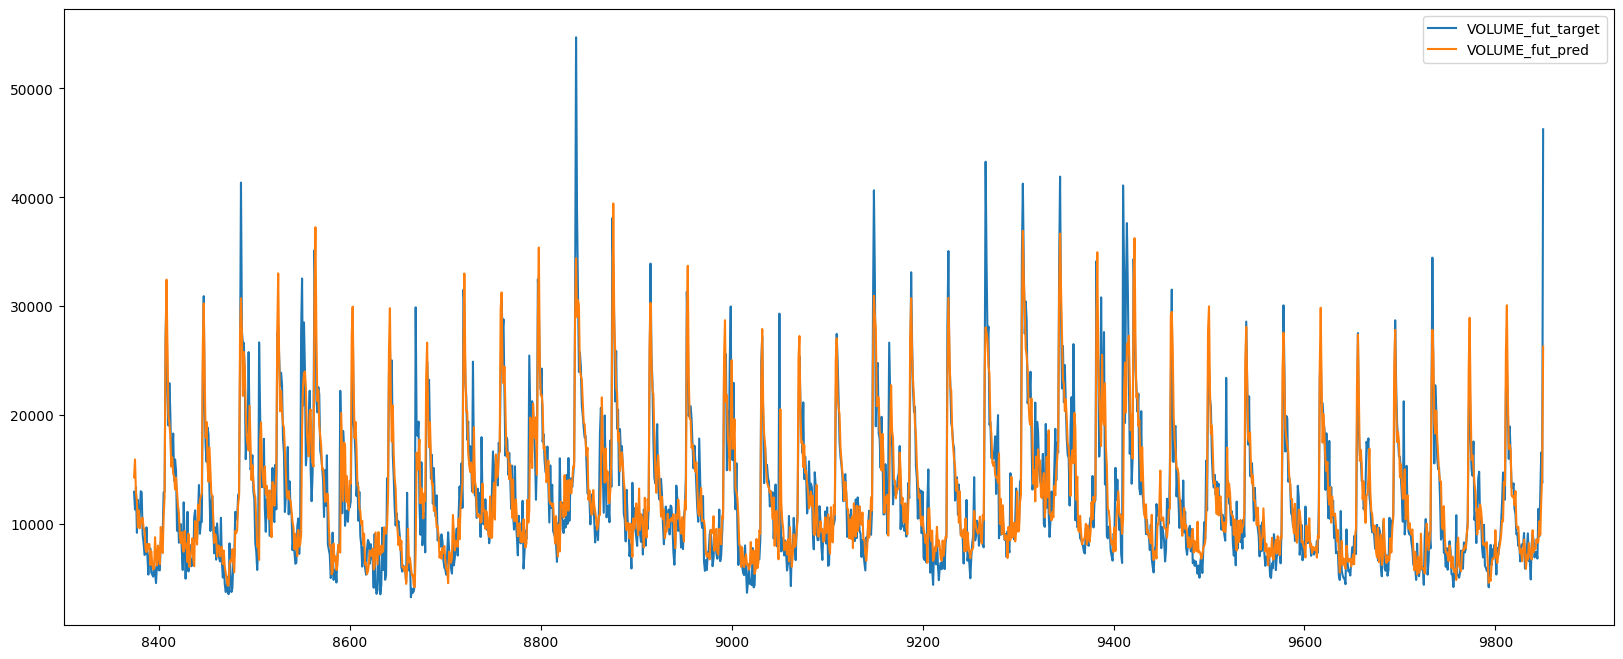

In [15]:
tdf_test[TARGET].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_fut_pred'].plot(figsize=[20, 8], legend=True)